In [1]:
##Borrar datos del entorno
rm(list=ls())

In [2]:
##Crear folders de almacenamiento
dir.create("microdatos", showWarnings = F)
#Cambiar directorio
setwd("microdatos")
# Create directories for each survey year
for (year in c("2016", "2018", "2020", "2022")) {
  dir.create(paste0("vivienda", year), showWarnings = FALSE)
}

In [3]:
#Función para crear tabla
crea_tabla <- function(df, titulo, subtitulo,nota="",nombre_archivo){

  # Format the numeric columns with commas
  formatted_df <- df #%>%
    #mutate(across(where(is.numeric), ~scales::comma(.)))

  # Checa si existe la columna "Organismo" para agrupar la tabla
  if("Organismo" %in% names(df)) {
    gt_table <- formatted_df %>%
      gt(rowname_col = "Organismo",
         groupname_col = "Año",
         row_group_as_column = TRUE)
  } else {
    gt_table <- formatted_df %>%
      gt()
  }

  gt_table <- gt_table %>%
    tab_options(
      column_labels.font.weight = "bold",
    ) %>%
    tab_header(
      title = md(paste0("**", titulo, "**")),
      subtitle=md(paste0("*", subtitulo, "*"))
    ) %>%
    tab_options(
      table.font.names = 'Poppins',
      source_notes.font.size = 8,
      table.border.top.width = px(0),
      table.border.bottom.width = px(0),
      column_labels.background.color = "#235b4eff",
      column_labels.font.size = 10,
    heading.title.font.size = 15,
    ) %>%
    cols_align(
      align = "center"
    ) %>%
    tab_source_note(
      source_note = md("")
    ) %>%
    tab_source_note(
      source_note = md(nota)
    ) %>%
    tab_source_note(
      source_note = md("Fuente: Elaboración propia con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)")
    )%>%
    cols_width(
      everything() ~ px(180)
    )

  # Salva la tabla
  gtsave(gt_table, filename = nombre_archivo)

  # Muestra la imagen
  img <- image_read(nombre_archivo)
  return(img)
}

In [4]:
options(survey.lonely.psu="adjust")

In [5]:
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,srvyr,janitor,survey,
               sf,httr,jsonlite,gt,magick,showtext)
#Fuente para los gráficos
font_add_google("Poppins", "pop")
showtext_auto()

Loading required package: pacman



In [6]:
# Función para descargar y descomprimir un archivo con timeout
download_and_unzip <- function(url, destination="microdatos") {
  tryCatch({
    # Descargar el archivo con timeout
    download.file(url, destfile = paste0(destination, "/", basename(url)), mode = "wb", timeout = 10000)

    # Descomprimir el archivo
    unzip(paste0(destination, "/", basename(url)), exdir = destination)

    # Eliminar el archivo comprimido después de descomprimirlo
    unlink(paste0(destination, "/", basename(url)))

    message(paste("Descarga y descompresión exitosas para", basename(url)))
  }, error = function(e) {
    warning(paste("Error al descargar o descomprimir", basename(url), ":", conditionMessage(e)))
  })
}

In [7]:
consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))
  return(df)
}

In [8]:
years<-c(2016,2018,2020,2022)

In [9]:
# Descargar y descomprimir los archivos de microdatos
for (year in years) {
  url <- paste0("https://www.inegi.org.mx/contenidos/programas/enigh/nc/", year, 
                "/microdatos/enigh", year, "_ns_viviendas_csv.zip")
  destination <- paste0("vivienda", year)
  download_and_unzip(url, destination)
}

Descarga y descompresión exitosas para enigh2016_ns_viviendas_csv.zip

Descarga y descompresión exitosas para enigh2018_ns_viviendas_csv.zip

Descarga y descompresión exitosas para enigh2020_ns_viviendas_csv.zip

Descarga y descompresión exitosas para enigh2022_ns_viviendas_csv.zip



In [10]:
# Descargar y descomprimir los archivos de microdatos
for (year in years) {
  url <- paste0("https://www.inegi.org.mx/contenidos/programas/enigh/nc/", year, 
                "/microdatos/enigh", year, "_ns_concentradohogar_csv.zip")
  destination <- paste0("vivienda", year)
  download_and_unzip(url, destination)
}

Descarga y descompresión exitosas para enigh2016_ns_concentradohogar_csv.zip

Descarga y descompresión exitosas para enigh2018_ns_concentradohogar_csv.zip

Descarga y descompresión exitosas para enigh2020_ns_concentradohogar_csv.zip

Descarga y descompresión exitosas para enigh2022_ns_concentradohogar_csv.zip



In [11]:
# Descargar y descomprimir los archivos de microdatos
for (year in years) {
  url <- paste0("https://www.inegi.org.mx/contenidos/programas/enigh/nc/", year, 
                "/microdatos/enigh", year, "_ns_poblacion_csv.zip")
  destination <- paste0("vivienda", year)
  download_and_unzip(url, destination)
}

Descarga y descompresión exitosas para enigh2016_ns_poblacion_csv.zip

Descarga y descompresión exitosas para enigh2018_ns_poblacion_csv.zip

Descarga y descompresión exitosas para enigh2020_ns_poblacion_csv.zip

Descarga y descompresión exitosas para enigh2022_ns_poblacion_csv.zip



In [12]:
viviendas <- list()
survey_objects <- list()


for (year in years) {
  file_path <- paste0("vivienda", year, "/viviendas.csv")
  vivienda <- read_csv(file_path)%>%
    # Generar clave de entidad federativa
    mutate(cve_ent = case_when(
        nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
        nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    ))%>%
janitor::clean_names()

viviendas[[as.character(year)]] <- vivienda
  
  # Convert the data frame to a survey object
  survey_objects[[as.character(year)]] <- vivienda %>%
                                           as_survey_design(weights = factor, strata = est_dis, ids = upm)
}

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use 

In [13]:
hogares <- list()
hogares_objects <- list()


for (year in years) {
  file_path <- paste0("vivienda", year, "/concentradohogar.csv")
  hogares <- read_csv(file_path)%>%
    # Generar clave de entidad federativa
    mutate(cve_ent = case_when(
        nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
        nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    ))%>%
janitor::clean_names()

hogares[[as.character(year)]] <- hogares
  
  # Convert the data frame to a survey object
  hogares_objects[[as.character(year)]] <- hogares %>%
                                           as_survey_design(weights = factor, strata = est_dis, ids = upm)
}

Rows: 70311 Columns: 127
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): folioviv, ubica_geo, ageb, est_dis, upm, educa_jefe
dbl (121): foliohog, tam_loc, est_socio, factor, clase_hog, sexo_jefe, edad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 74647 Columns: 126
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): folioviv, ubica_geo, est_dis, upm, educa_jefe
dbl (121): foliohog, tam_loc, est_socio, factor, clase_hog, sexo_jefe, edad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 89006 Columns: 126
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): folioviv, ubica_geo, est_dis, upm, e

In [14]:
poblacion <- list()
pob_objects <- list()
filtro_entidad="09"


for (year in years) {
  file_path <- paste0("vivienda", year, "/poblacion.csv")
  poblacion <- read_csv(file_path)%>%
    # Generar clave de entidad federativa
    mutate(cve_ent = case_when(
        nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
        nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    ))%>%
janitor::clean_names()%>%
filter(cve_ent==filtro_entidad)

poblacion[[as.character(year)]] <- poblacion
  

}

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 257805 Columns: 178
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (30): folioviv, numren, madre_id, padre_id, lenguaind, nivel, residenci...
dbl (122): foliohog, parentesco, sexo, edad, madre_hog, padre_hog, disc1, di...
lgl  (26): disc6, disc7, causa6, causa7, noatenc_4, noatenc_6, noatenc_7, no...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 269206 Columns: 178
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (30): folioviv, numren, madre_id, padre_id, disc1, causa1, lenguaind, n...
dbl

# **Viviendas en renta en la Ciudad de México**

In [15]:
filtro_entidad="09"
filtro_tenencia=1
# Initialize an empty tibble to store the aggregated data
datos_rentadas <- tibble()

# Loop through each year to process survey data
for (year in years) {
  datos_anuales <- survey_objects[[as.character(year)]] %>%
    filter(cve_ent == filtro_entidad) %>%
group_by(tenencia)%>%
    summarise(
      viviendas = survey_total(vartype = "cv"),
      pct = survey_prop(vartype = "cv")*100
    ) %>%
ungroup()%>%
    mutate(year = year)%>%
filter(tenencia==filtro_tenencia)
  
  # Bind the annual data to the main tibble
  datos_rentadas <- bind_rows(datos_rentadas, datos_anuales)
}

In [16]:
datos_rentadas

tenencia,viviendas,viviendas_cv,pct,pct_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,684532,0.05203234,24.66978,5.065957,2016
1,694623,0.05102003,25.49647,4.873633,2018
1,585836,0.05102828,21.64027,4.968355,2020
1,681204,0.04449348,23.10770,4.467825,2022


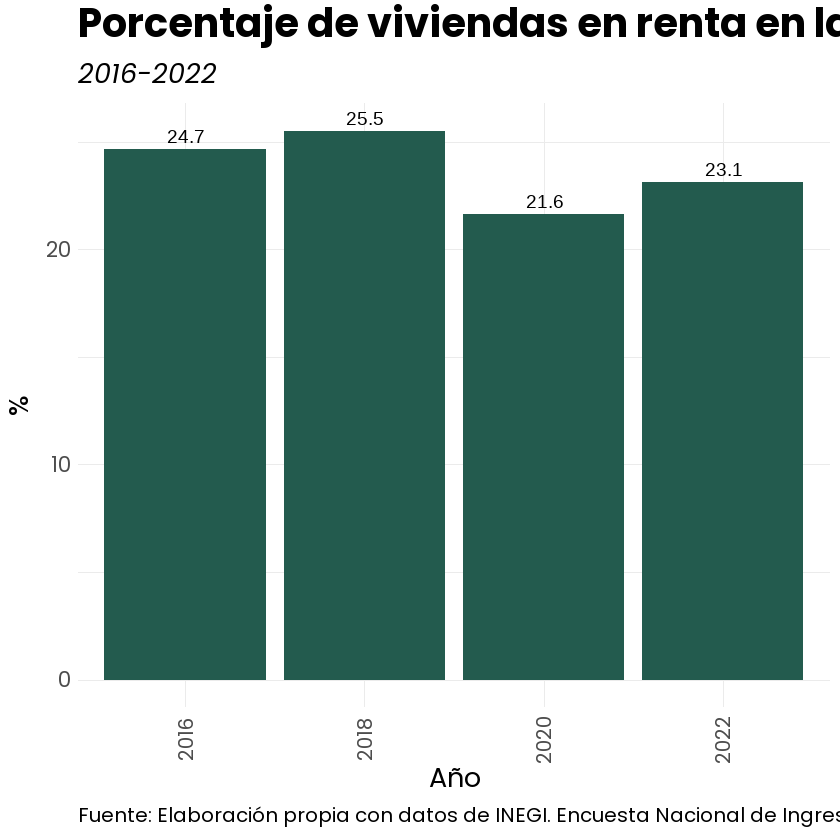

In [44]:
#Crear gráfica de barras con porcentaje de viviendas rentadas
datos_rentadas %>%
  ggplot(aes(x = factor(year), y = pct)) +
geom_col(fill="#235B4E")+
theme_minimal()+
geom_text(aes(label=round(pct,1)),vjust=-0.5,size=5,colour="black")+
theme_minimal()+
    labs(
    title ="Porcentaje de viviendas en renta en la Ciudad de México",
    subtitle = "2016-2022",
    caption = "Fuente: Elaboración propia con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares, 2016-2022.",    
x="Año",
    y="%")+
    theme(#axis.text.x = element_text(angle = 45, hjust = 1),
            plot.title = element_text(hjust = 0, size=30,face="bold"),
            plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
            plot.caption = element_text(hjust = 0,size=15),
            axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
            text=element_text("pop",size=20))

#Salvar gráfica
ggsave("vivi_renta.png",width=13,height=8, dpi=100)

# **Viviendas en renta por tipo de vivienda**

In [18]:
rentadas_tipo <- tibble()
    for (year in years) {
    datos_anuales <- survey_objects[[as.character(year)]] %>%
    filter(cve_ent == filtro_entidad) %>%
    group_by(tenencia,tipo_viv)%>%
    summarise(
        viviendas = survey_total(vartype = "cv"),
        pct = survey_prop(vartype = "cv")*100
        ) %>%
    ungroup()%>%
    mutate(year = year)%>%
    filter(tenencia==filtro_tenencia)%>%
mutate(tipo_viv=case_when(
    tipo_viv==1~"Casa independiente",
    tipo_viv==2~"Departamento en edificio",
    tipo_viv==3~"Vivienda en vecindad",
    tipo_viv==4~"Cuarto de azotea",
    tipo_viv==5~"Local no construido para habitación",
TRUE~"No especificado"))

    
    # Bind the annual data to the main tibble
    rentadas_tipo <- bind_rows(rentadas_tipo, datos_anuales)
    }


In [19]:
rentadas_tipo <- rentadas_tipo %>%
  arrange(factor(year), desc(pct)) %>%
  mutate(tipo_viv = factor(tipo_viv, levels = unique(tipo_viv)))

In [20]:
paleta<-c("#235B4E", "#9F2241","#BC955C","#98989A","#e3c8a6ff","black")


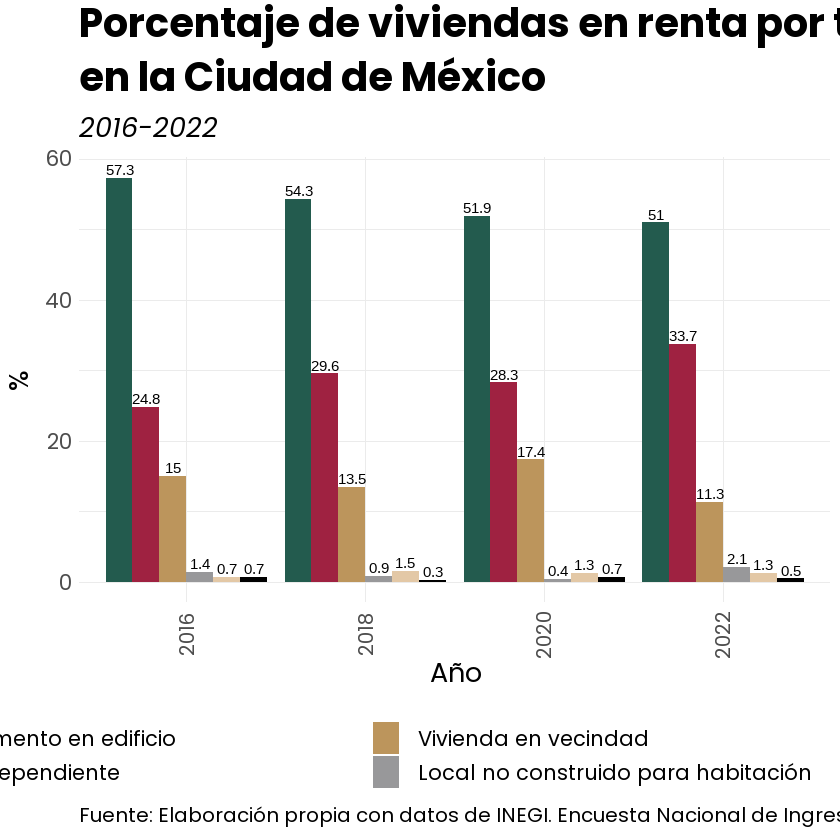

In [49]:
#Graficar porcentaje de viviendas rentadas por tipo de vivienda
rentadas_tipo %>%
  ggplot(aes(x = factor(year), y = pct, fill = tipo_viv)) +
geom_col(position = "dodge")+
geom_text(aes(label = round(pct, 1)), position = position_dodge(width = 0.9), vjust = -0.3, size = 4, color = "black")+
scale_fill_manual(values = paleta) +
theme_minimal()+
    labs(
    title =("Porcentaje de viviendas en renta por tipo
en la Ciudad de México"),
    subtitle = "2016-2022",
    caption = "Fuente: Elaboración propia con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares, 2016-2022.",
    x="Año",
    fill = "Tipo de vivienda",
    y="%")+
    theme(#axis.text.x = element_text(angle = 45, hjust = 1),
            plot.title = element_text(hjust = 0, size=30,face="bold"),
        legend.position = "bottom",
            plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
            plot.caption = element_text(hjust = 0,size=15),
            axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
            text=element_text("pop",size=20))

#Salvar gráfica
ggsave("vivi_renta_tipo.png",width=15,height=8,dpi=100)

# **Viviendas en renta por promedio de integrantes**

In [22]:
integrantes <- tibble()

for (year in years) {
  datos_anuales <- survey_objects[[as.character(year)]] %>%
    filter(cve_ent == filtro_entidad) %>%
    group_by(tenencia) %>%
    summarise(
      integrantes = survey_mean(tot_resid, vartype = "cv")
    ) %>%
    ungroup() %>%
    mutate(year = year) %>%
    filter(tenencia == filtro_tenencia)
  
  # Bind the annual data to the main tibble
  integrantes <- bind_rows(integrantes, datos_anuales)
}

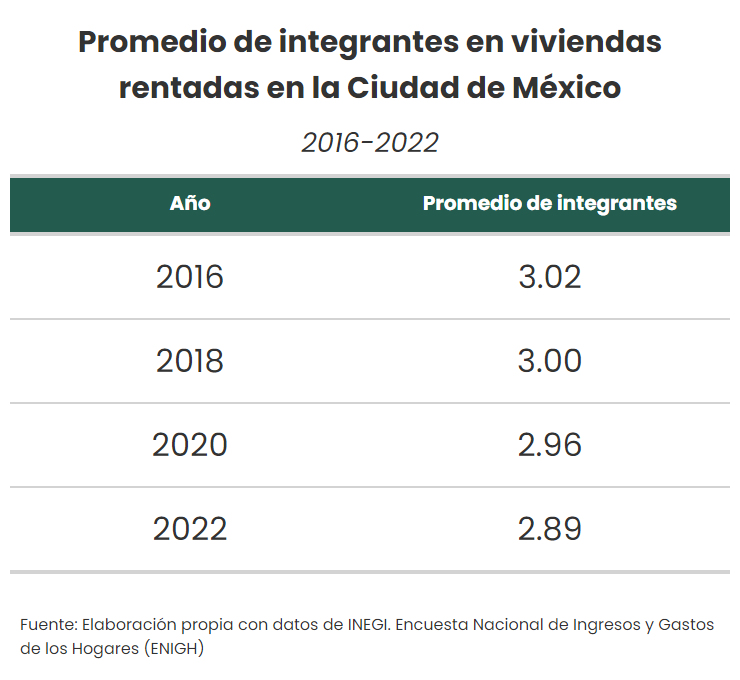

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      740    680 sRGB       FALSE    37541 72x72  

In [23]:
integrantes%>%
select(year,integrantes)%>%

mutate(integrantes=round(integrantes,2))%>%
rename("Año"=year,"Promedio de integrantes"=integrantes)%>%
crea_tabla("Promedio de integrantes en viviendas rentadas en la Ciudad de México",
           "2016-2022",
           " ",
           "integ_rent_cdmx.png")

# **Viviendas en renta por promedio de cuartos**

In [24]:
#Integrantes por cuartos 
cuartos<-tibble()

for (year in years) {
  datos_anuales <- survey_objects[[as.character(year)]] %>%
    filter(cve_ent == filtro_entidad) %>%
    filter(tenencia == filtro_tenencia)%>%
    summarise(integrantes=survey_total(tot_resid, vartype="cv"),
              cuartos=survey_total(num_cuarto,vartype="cv"))%>%
mutate(year=year)
  
  # Bind the annual data to the main tibble
  cuartos <- bind_rows(cuartos, datos_anuales)
}


In [25]:
cuartos

integrantes,integrantes_cv,cuartos,cuartos_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2067152,0.05484360,2459662,0.05362822,2016
2082896,0.05434958,2482649,0.05800231,2018
1734211,0.05572384,1968296,0.05717316,2020
1970824,0.04788656,2484548,0.04833186,2022


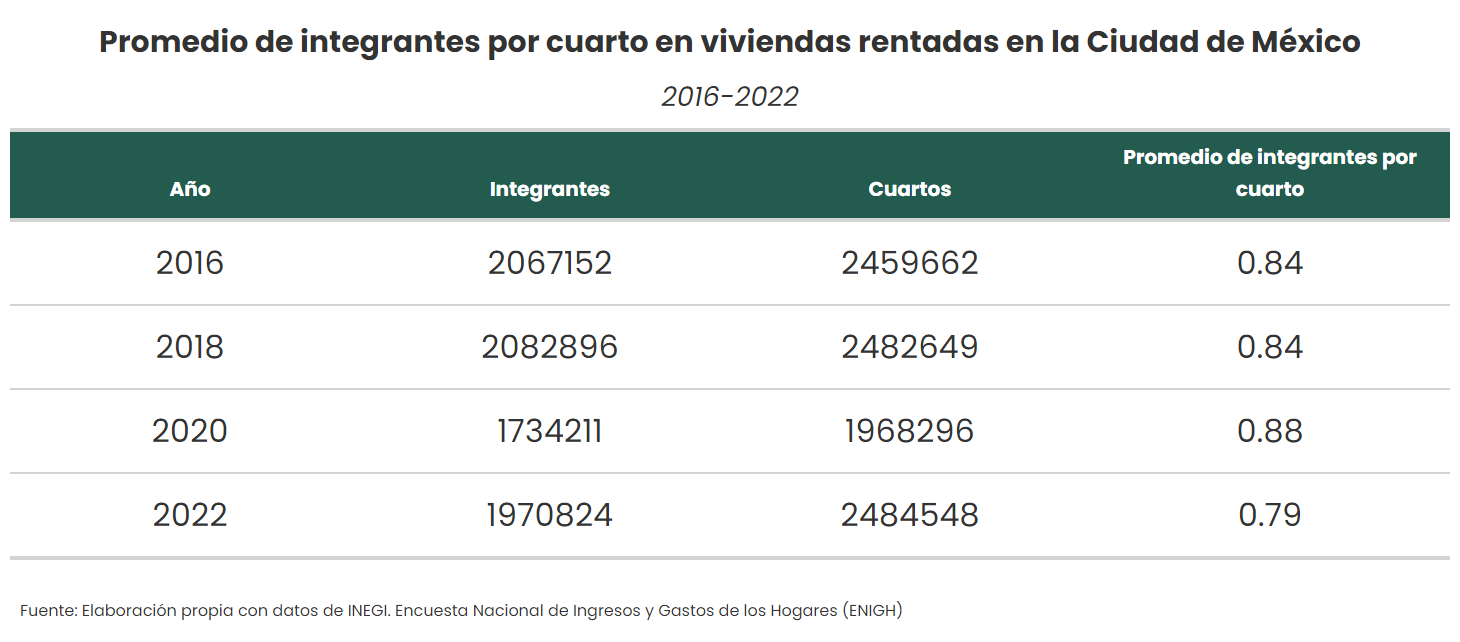

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1460    642 sRGB       FALSE    54566 72x72  

In [26]:
cuartos%>%
select(year,integrantes,cuartos)%>%
mutate(intcuarto=round(integrantes/cuartos,2))%>%
rename("Año"=year,"Integrantes"=integrantes,"Cuartos"=cuartos,"Promedio de integrantes por cuarto"=intcuarto)%>%  
crea_tabla("Promedio de integrantes por cuarto en viviendas rentadas en la Ciudad de México",
           "2016-2022",
           " ",
           "integ_rent_cuarto_cdmx.png")

# **Viviendas en renta por antigüedad**

In [27]:
edad_vivienda <- tibble()

for (year in years) {
  datos_anuales <- survey_objects[[as.character(year)]] %>%
    filter(cve_ent == filtro_entidad) %>%
    filter(tenencia == filtro_tenencia)%>%
  mutate(catego=case_when(antiguedad==0 & antiguedad<10 ~ "0 y menos de 10 años",
                          antiguedad>=10 & antiguedad<30 ~ "10 y menos de 30 años",
                          antiguedad>=30 & antiguedad<50 ~ "30 y menos de 50 años",
                          antiguedad>=50 ~ "Más de 50 años",
                          TRUE ~ "No especificado"))%>%
filter(catego!="No especificado")%>%
    group_by(catego)%>%
    summarise(
      viviendas = survey_total(vartype = "cv"),
      pct = survey_prop(vartype = "cv")*100
    ) %>%
    ungroup()%>%
    mutate(year = year)
    
    # Bind the annual data to the main tibble
    edad_vivienda <- bind_rows(edad_vivienda, datos_anuales)   
}

In [28]:
edad_vivienda <- edad_vivienda %>%

mutate(catego=fct_relevel(catego,"0 y menos de 10 años",
                     "10 y menos de 30 años",
                     "30 y menos de 50 años",
                     "Más de 50 años"))

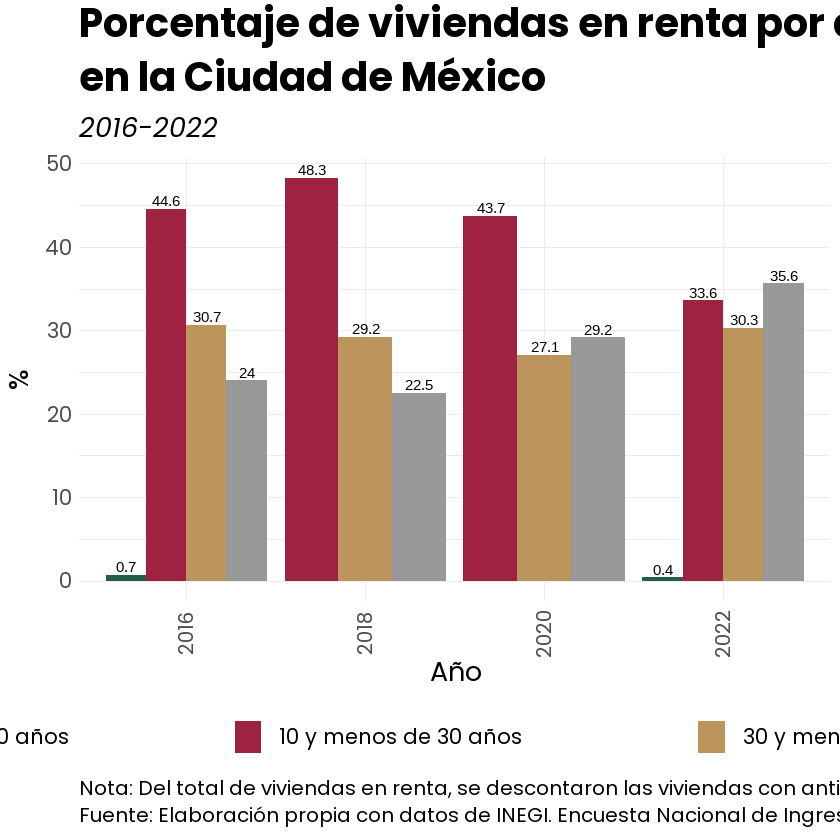

In [53]:
edad_vivienda %>%
  ggplot(aes(x = factor(year), y = pct, fill = catego)) +
geom_col(position = "dodge")+
geom_text(aes(label = round(pct, 1)), position = position_dodge(width = 0.9), vjust = -0.3, size = 4, color = "black")+
scale_fill_manual(values = paleta) +
theme_minimal()+
    labs(
    title ="Porcentaje de viviendas en renta por antigüedad
en la Ciudad de México",
    subtitle = "2016-2022",
    caption = "Nota: Del total de viviendas en renta, se descontaron las viviendas con antigüedad no especificada.
Fuente: Elaboración propia con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares, 2016-2022.",
    x="Año",
    fill = "Tipo de vivienda",
    y="%")+
    theme(#axis.text.x = element_text(angle = 45, hjust = 1),
            plot.title = element_text(hjust = 0, size=30,face="bold"),
        legend.position = "bottom",
            plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
            plot.caption = element_text(hjust = 0,size=15),
            axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
            text=element_text("pop",size=20))


#Salvar gráfica
ggsave("vivi_renta_antiguedad.png",width=15,height=8, dpi=100)

In [30]:
# Renta promedio en CDMX

renta_promedio <- tibble()  

for (year in years) {
    datos_anuales <- survey_objects[[as.character(year)]] %>%
        filter(cve_ent == filtro_entidad) %>%
        filter(tenencia == filtro_tenencia)%>%
summarise(
        renta_prom = survey_mean(renta, vartype = "cv")
        ) %>%
        mutate(year = year)%>%
    mutate(renta_prom=round(renta_prom,2))

    
    # Bind the annual data to the main tibble
    renta_promedio <- bind_rows(renta_promedio, datos_anuales)
    }


In [31]:
renta_promedio

renta_prom,renta_prom_cv,year
<dbl>,<dbl>,<dbl>
4997.78,0.05756269,2016
5353.91,0.06164438,2018
5073.17,0.07021812,2020
5944.25,0.05580207,2022


In [32]:
url_inegi<-"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/628194/es/0700/false/BIE/2.0/ef8c858c-1f87-6408-5630-fb5496f609bf/?type=json"


In [33]:
#Obtener inpc de api de 2016 a 2022
inpc<-consulta_api(url_inegi)%>%
pluck("Series")%>%
pluck("OBSERVATIONS")%>%
as.data.frame()%>%
janitor::clean_names()%>%
#Filtrar fecha
filter(time_period >= "2016/01" & time_period <= "2022/12")%>%
mutate(obs_value=as.numeric(obs_value))%>%
#Extrar mes y año de la variable time_period
separate(time_period, into = c("año", "mes"), sep = "/")%>%
#Obtener el promedio anual
group_by(año)%>%
summarise(obs_value=mean(obs_value))%>%
#Cambiar la base del inpc a 2022=100
mutate(inpcbase=obs_value/obs_value[nrow(.)]*100)%>%
mutate(año=as.integer(año))

In [34]:
inpc

año,obs_value,inpcbase
<int>,<dbl>,<dbl>
2016,90.12792,73.56931
2017,95.57296,78.01397
2018,100.25542,81.83615
2019,103.90067,84.81168
2020,107.43000,87.69259
2021,113.54192,92.68160
2022,122.50750,100.00000


In [35]:
#Unir renta promedio con inpc
renta_promedio<-renta_promedio%>%
left_join(inpc,by=c("year"="año"))%>%
mutate(renta_prom2022=round(renta_prom*inpcbase/100,2))

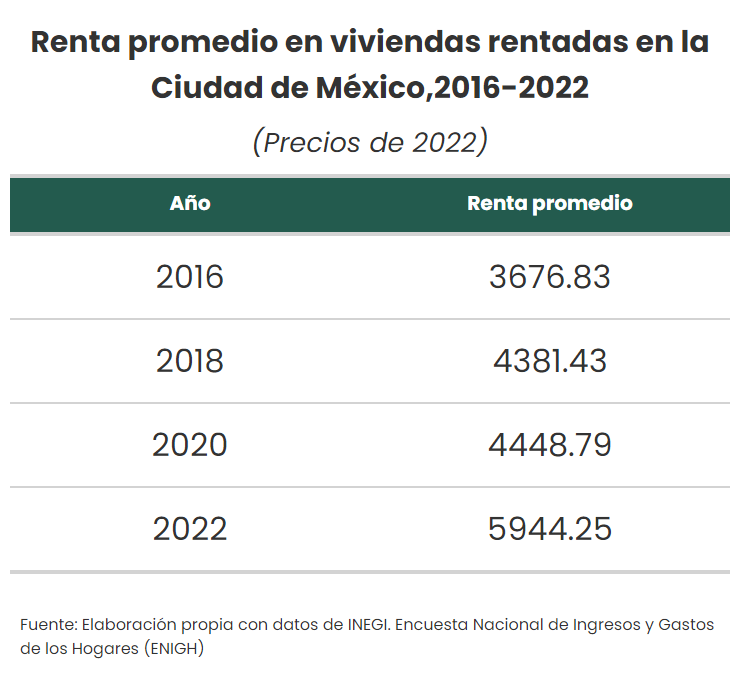

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      740    680 sRGB       FALSE    44395 72x72  

In [55]:
#Unir renta promedio con inpc
renta_promedio%>%
select(year,renta_prom2022)%>%
rename("Año"=year,"Renta promedio"=renta_prom2022)%>%
crea_tabla("Renta promedio en viviendas rentadas en la Ciudad de México,2016-2022",
           "(Precios de 2022)",
           " ",
           "renta_promedio_cdmx.png")

# **Hogares en viviendas rentadas en la Ciudad de México**

In [37]:
filtro_entidad="09"
filtro_tenencia=1

viviendarenta<-list()

for (year in years) {
  file_path <- paste0("vivienda", year, "/viviendas.csv")
  vivienda <- read_csv(file_path)%>%
    # Generar clave de entidad federativa
    mutate(cve_ent = case_when(
        nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
        nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    ))%>%
janitor::clean_names()%>%
filter(cve_ent==filtro_entidad)%>%
filter(tenencia==filtro_tenencia)%>%
mutate(year=year)%>%
mutate(id_renta=1)%>%
select(year,folioviv,id_renta)

viviendarenta[[as.character(year)]] <- vivienda

}

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use 

In [38]:
#Pegar con hogares de acuerdo al año y folioviv
hogares_renta<-list()
survey_hogrenta <- list()


for (year in years) {
  file_path <- paste0("vivienda", year, "/concentradohogar.csv")
  hogares <- read_csv(file_path)%>%
    # Generar clave de entidad federativa
    mutate(cve_ent = case_when(
        nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
        nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    ))%>%
  #Clasificar tipo de hogares
  mutate(clasifhog=case_when(
  clase_hog==1 | clase_hog==5 ~ "Hogar no familiar",
  TRUE ~ "Hogar familiar"))%>%
janitor::clean_names()%>%
filter(cve_ent==filtro_entidad)%>%
mutate(year=year)%>%
left_join(viviendarenta[[as.character(year)]],by=c("year","folioviv"))

hogares_renta[[as.character(year)]] <- hogares

survey_hogrenta[[as.character(year)]] <- hogares %>%
                                           as_survey_design(weights = factor, strata = est_dis, ids = upm)

}   


Rows: 70311 Columns: 127
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): folioviv, ubica_geo, ageb, est_dis, upm, educa_jefe
dbl (121): foliohog, tam_loc, est_socio, factor, clase_hog, sexo_jefe, edad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 74647 Columns: 126
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): folioviv, ubica_geo, est_dis, upm, educa_jefe
dbl (121): foliohog, tam_loc, est_socio, factor, clase_hog, sexo_jefe, edad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 89006 Columns: 126
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): folioviv, ubica_geo, est_dis, upm, e

In [39]:
#Obtener hgoares que rentan por clasificación
hog_renta_clasif <- tibble()

for (year in years) {
  datos_anuales <- survey_hogrenta[[as.character(year)]] %>%
filter(!is.na(id_renta))%>%
    group_by(clasifhog)%>%
    summarise(
      hogares = survey_total(vartype = "cv"),
      pct = survey_prop(vartype = "cv")*100
    ) %>%
    ungroup()%>%
    mutate(year = year)
    
    # Bind the annual data to the main tibble
    hog_renta_clasif <- bind_rows(hog_renta_clasif, datos_anuales)
}

In [40]:
hog_renta_clasif <- hog_renta_clasif %>%
  arrange(factor(year), desc(pct)) %>%
  mutate(clasifhog = factor(clasifhog, levels = unique(clasifhog)))

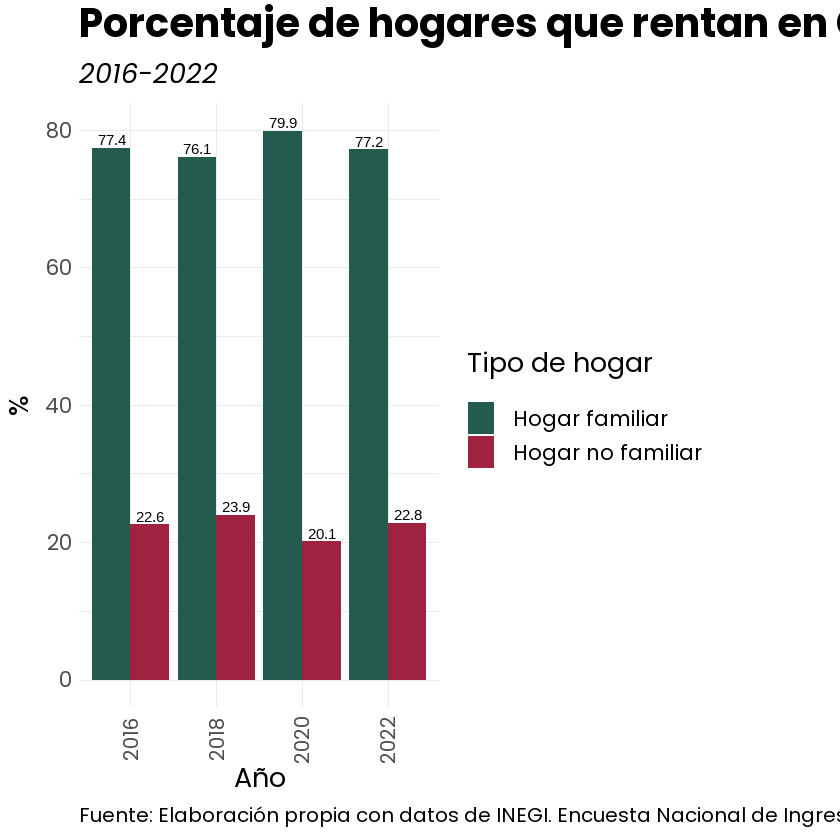

In [57]:
#Graficar porcentaje de viviendas rentadas por tipo de vivienda
hog_renta_clasif %>%
  ggplot(aes(x = factor(year), y = pct, fill = clasifhog)) +
geom_col(position = "dodge")+
geom_text(aes(label = round(pct, 1)), position = position_dodge(width = 0.9), vjust = -0.3, size = 4, color = "black")+
scale_fill_manual(values = paleta) +
theme_minimal()+
    labs(
    title ="Porcentaje de hogares que rentan en Ciudad de México por tipo",
    subtitle = "2016-2022",
    caption = "Fuente: Elaboración propia con datos de INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares, 2016-2022.",
    x="Año",
    fill = "Tipo de hogar",
    y="%")+
    theme(#axis.text.x = element_text(angle = 45, hjust = 1),
            plot.title = element_text(hjust = 0, size=30,face="bold"),
        legend.position = "right",
            plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
            plot.caption = element_text(hjust = 0,size=15),
            axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
            text=element_text("pop",size=20))


#Salvar gráfica
ggsave("hog_renta_clasif_cdmx.png",width=15,height=8, dpi=100)